In [2]:
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../../RKLM_Python/')
# Path to output files
sys.path.append('../')

import numpy as np
import utils
import plotting_tools as pt

from importlib import reload
import utils
utils = reload(utils)
pt = reload(pt)

from scipy import signal
import pickle

# For which test case do we plot?
`swe` is the shallow water vortex, `euler` the Euler vortex and `rb` the rising bubble.

In [119]:
swe = False
euler = True
rb = False

# plot rhou?
rhou = False
vortz = False
pot_temp = False
exner = True

# plot end time?
end = False

# Initial distribution plotter

-5.8778534 0.7390356
[-5. -4. -3. -2. -1.  0.]


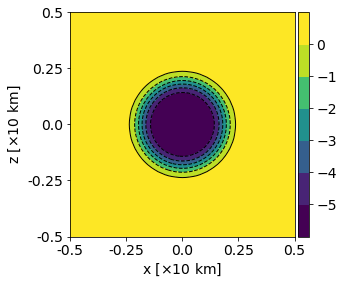

In [121]:
# initial time-step
times = [0]
tag = 'ic'
if rb and end:
    times = [163]
    tag = 'after_full_step'
    
N = 1 # ensemble size
l_typ = 'WINDOW_STEP'

def ic_loader(tc,sfx1, swe):
    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx1,format='dat')
    path_pickle = tc.get_path(fn_pickle)

    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    file.close()

#     if swe:
#         p_ref = ud.h_ref
#     else:
#         p_ref = ud.p_ref
#     Msq = ud.Msq
    return ud

def get_ens(tc, sfx , diff, attribute, swe=False, rhou=False):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tag)[1]
    ud = ic_loader(tc,sfx,swe)
    if swe:
        ens = ens[:,0,:]
    if attribute == 'p2_nodes': # convert to pressure p
        ens -= ens.mean() # pi is correct up to a mean, dimensionless
        ens *= ud.Msq # pi is the perturbation variable
        ens *= 1e4 # scale colourbar
    if attribute == 'rhou':
        ens = ens * ud.rho_ref * ud.u_ref # units in kg m^{-1} s^{-1}
    if attribute == 'vortz':
        ens = ens # units in 0.01 s^{-1}
    if attribute == 'rhoY':
        rho = tc.get_ensemble(times, N, 'rho', sfx, label_type=l_typ, avg=True, diff=diff, tag=tag)[1]
        ens /= rho # units in 300 K

    label = sfx + '_' + attribute
    return label, ens.T

diff = False
if swe:
    attribute = 'p2_nodes'
    et = 1.0
    base_fn = "output_swe_vortex"
    directory = "output_swe_vortex"
    py_directory = "../../%s/" %directory

    Nx, Ny, Nz = 64, 1, 64
    tc = utils.test_case(base_fn,py_directory,Nx,Ny,et,Nz=Nz)
    
    sfx1 = 'comp_bal_noib'
    l1, a1 = get_ens(tc, sfx1, diff, attribute,swe=True)
    la = 'SWE vortex'
    aa = a1
    lvls = np.arange(-0.003,0.0006,0.0005) * 100.0
#     lvls = None
    lbl = 'swe'
elif euler:
    if rhou:
        attribute = 'rhou'
    elif vortz:
        attribute = 'vortz'
    elif pot_temp:
        attribute = 'rhoY'
    elif exner:
        attribute = 'p2_nodes'
    et = 1.0
    base_fn = "output_travelling_vortex"
    directory = "output_travelling_vortex"
    py_directory = "../../%s/" %directory

    Nx, Ny = 64, 64
    tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
    
    sfx1 = 'comp_bal_noib'
    l2, a2 = get_ens(tc, sfx1, diff, attribute, rhou=rhou)
#     la = 'Euler vortex'
    la = r'$\rho u$' if rhou else r'$\pi$'
    la = ''
    aa = a2
    
    lbl = 'euler'
    if rhou:
        lvls = np.arange(50,120,5)
        lbl += '_rhou'
    elif vortz:
        lvls = np.arange(-0.022,0.038,0.010) * 100
        lbl += '_vortz'
    elif pot_temp:
        lvls = np.arange(1.10,2.0,0.10) #/ 300.0
        lbl += '_pt'
    elif exner:
        lvls = np.arange(-0.0005,0.0001, 0.0001) * 1e4
        lbl += '_exner'
        
elif rb:
    et = 1.0
    base_fn = "output_rising_bubble"
    directory = "output_rising_bubble"
    py_directory = "../../%s/" %directory
    
    Nx, Ny = 160, 80
    tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
    
    sfx1 = 'comp_imbal_half_CFLfixed_ib-0'
#     sfx1 = 'truth_CFLfixed_ib-0'
    _, a1 = get_ens(tc, sfx1, diff, 'rho')
    _, a2 = get_ens(tc, sfx1, diff, 'rhoY')
    la = 'Rising bubble'
    la = ''
    aa = a2/a1 * 300
    if end:
        lvls = np.linspace(299.75,302.0,10)
        lvls = np.linspace(300.25,302.0,8)
#         lvls = np.linspace(299.5,302.0,11)
        lvls = np.arange(300.25,301.75,.25)
    else:
#         lvls = np.linspace(300.0,302.0,11)
        lvls = np.linspace(299.75,302.0,10)
        lvls = np.linspace(300.25,302.0,8)
        lvls = np.arange(300.25,302,0.25)
    lbl = 'rb'
    
print(aa.min(),aa.max())
print(lvls)
ll = [aa, la]
pl_lst = [ll]

if swe or euler:
    x_axs = [-0.5,-0.25,0.0,0.25,0.5]
    y_axs = [-0.5,-0.25,0.0,0.25,0.5]
    pl = pt.plotter(pl_lst,ncols=1,figsize=(5,5),sharey=False)
else:
    x_axs = [-1.0,-0.5,0.0,0.5,1.0]
    y_axs = [0.0,0.25,0.5,0.75,1.0]
    pl = pt.plotter(pl_lst,ncols=1,figsize=(8,4),sharey=False)
    
if swe: 
    x_label = r'x [$\times 100$ m]'
    y_label = r'y [$\times 100$ m]'
    x_loc = np.linspace(0,Nx-1,5)
    y_loc = np.linspace(0,Nz-1,5)
    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
else:
    x_label = r'x [$\times 10$ km]'
    y_label = r'z [$\times 10$ km]'
    if exner or vortz:
        x_loc = np.linspace(0,Nx,5)
        y_loc = np.linspace(0,Ny,5)
    else:
        x_loc = np.linspace(0,Nx-1,5)
        y_loc = np.linspace(0,Ny-1,5)
    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
_ = pl.plot(aspect='equal',method='contour',lvls=lvls)

out_t = 'final' if end else 'initial'
pl.save_fig('./output/%s_%s' %(out_t,lbl))

# Truth plotter

-8.4624605 8.4624605
-8.4624605 8.4624605


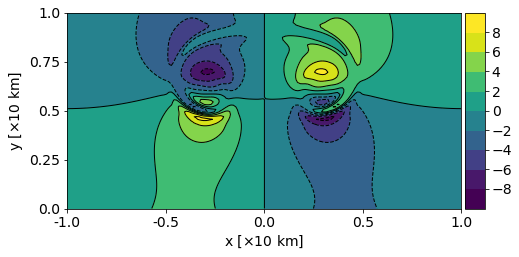

In [384]:
l_typ = 'TIME'
N = 1

def ic_loader(tc, sfx1, swe, lbl):
    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx1,format='dat')
    path_pickle = tc.get_path(fn_pickle)

    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    file.close()

    if lbl == 'swe':
        p_ref = ud.d_ref * ud.u_ref
    elif lbl == 'euler':
        if rhou:
            p_ref = ud.rho_ref * ud.u_ref
        else:
            p_ref = ud.p_ref * ud.Msq
    elif lbl == 'rb':
        p_ref = ud.rho_ref * ud.u_ref
    return p_ref

def get_ens(tc, times, sfx , diff, attribute, lbl, swe=False):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag='after_full_step')[1]
    p_ref = ic_loader(tc,sfx,swe,lbl)
    if swe:
        ens = ens[:,0,:]
    if attribute == 'p2_nodes':
        ens = ens * p_ref
    if attribute == 'rhou':
        ens = ens * p_ref

    label = sfx + '_' + attribute
    return label, ens.T

diff = False
if swe:
    base_fn = "output_swe_vortex"
    directory = "output_swe_vortex"
    py_directory = "../../%s/" %directory
    
    et = 3.0
    times = [3.0]
    attr = 'rhou'
    lbl = 'swe'
    Nx, Ny, Nz = 64, 1, 64
    swe_tc = utils.test_case(base_fn,py_directory,Nx,Ny,et,Nz=Nz)
    
    sfx1 = 'truth_ib-0'
    l1, a1 = get_ens(swe_tc, times, sfx1, diff, attr, lbl, swe=True)
    la = 'SWE_vortex'
    aa = a1
elif euler:
    base_fn = "output_travelling_vortex"
    directory = "output_travelling_vortex"
    py_directory = "../../%s/" %directory

    et = 3.0
    times = [3.0]
    attr = 'rhou' if rhou else 'p2_nodes'
    lbl = 'euler'
    Nx, Ny = 64, 64
    euler_tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
    
    sfx1 = 'truth_ib-0'
    l2, a2 = get_ens(euler_tc, times, sfx1, diff, attr, lbl)
    la = 'Euler vortex'
    aa = a2
    lvls = np.arange(-0.0065,0.0015,0.0010) * 100.0
elif rb:
    base_fn = "output_rising_bubble"
    directory = "output_rising_bubble"
    py_directory = "../../%s/" %directory
    
    et = 1.0
    times = [et]
    times = [1.0]
    attr = 'rhou'
    lbl = 'rb'
    Nx, Ny = 160, 80
    rb_tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
    
    sfx1 = 'truth_CFLfixed_ib-0'
#     sfx1 = 'comp_imbal_half_CFLfixed_ib-0'
    _, a1 = get_ens(rb_tc, times, sfx1, diff, attr, lbl)
    la = 'Rising bubble'
    aa = a1
    print(aa.min(),aa.max())
    lvls = np.linspace(300.0,302.0,11)
    
print(aa.min(),aa.max())
ll = [aa, '']
pl_lst = [ll]

if swe: 
    x_label = r'x [$\times 100$ m]'
    y_label = r'y [$\times 100$ m]'
    x_loc = np.linspace(0,Nx-1,5)
    y_loc = np.linspace(0,Nz-1,5)
    x_axs = [-0.5,-0.25,0.0,0.25,0.5]
    y_axs = [-0.5,-0.25,0.0,0.25,0.5]
    axvline = 31.5
    axhline = 31.5
    pl = pt.plotter(pl_lst,ncols=1,figsize=(10,5),sharey=False)
elif euler:
    x_label = r'x [$\times 10$ km]'
    y_label = r'y [$\times 10$ km]'
    if rhou:
        x_loc = np.linspace(0,Nx-1,5)
        y_loc = np.linspace(0,Ny-1,5)
        axvline = 31.5
        axhline = 31.5
        lvls = np.arange(60,120,10)
    else:
        x_loc = np.linspace(0,Nx,5)
        y_loc = np.linspace(0,Ny,5)
        axvline = 32
        axhline = 32
        lvls = np.arange(-60,10,10)
    x_axs = [-0.5,-0.25,0.0,0.25,0.5]
    y_axs = [-0.5,-0.25,0.0,0.25,0.5]

    pl = pt.plotter(pl_lst,ncols=1,figsize=(10,5),sharey=False)
elif rb:
    x_label = r'x [$\times 10$ km]'
    y_label = r'y [$\times 10$ km]'
    x_loc = np.linspace(0,Nx-1,5)
    y_loc = np.linspace(0,Ny-1,5) 
    x_axs = [-1.0,-0.5,0.0,0.5,1.0]
    y_axs = [0.0,0.25,0.5,0.75,1.0]
    pl = pt.plotter(pl_lst,ncols=1,figsize=(8,4),sharey=False)
    lvls = np.arange(-8,10,2)
    
if rb:
    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
else:
    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label, axhline=axhline, axvline=axvline)
_ = pl.plot(aspect='equal',method='contour',lvls=lvls)

rhou_lbl = '_rhou' if rhou else ''
pl.save_fig('./output/%s_truth%s' %(lbl,rhou_lbl))

# Observation plotter

For simulations with data assimilation, all data assimilation associated arrays are saved in the `.dat` file as pickled instances. This setting to output pickled data is toggled by the `da_debug` switch. The arrays are loaded (*unpickled*) in order.

9.313681 -69.68198


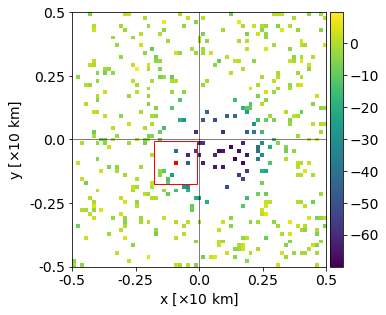

In [122]:
import matplotlib.patches as patches

if swe:
    Nx, Ny, Nz = 64, 1, 64
    et = 3.0
    base_fn = 'output_swe_vortex'
    pydir = '../../%s/' %base_fn
    tc = utils.test_case(base_fn, pydir, Nx, Ny, et, Nz=Nz)
elif euler:
    Nx, Ny = 64, 64
    et = 3.0
    base_fn = 'output_travelling_vortex'
    pydir = '../../%s/' %base_fn
    tc = utils.test_case(base_fn, pydir, Nx, Ny, et)
elif rb:
    Nx, Ny = 160, 80
    et = 1.0
    base_fn = 'output_rising_bubble'
    pydir = '../../%s/' %base_fn
    tc = utils.test_case(base_fn, pydir, Nx, Ny, et)

tags = tc.get_tag_dict()

N = 10
if swe:
    sfx0 = 'wdawloc_rhou_rhow_wda_ib-0'
#     p_ref = 1.0 # unit of contours in [m]
    lbl = 'swe'
elif euler:
    sfx0 = 'wdawloc_all_wda_ib-0'
#     dimensionless, [x 10^5]
    lbl = 'euler'
elif rb:
    sfx0 = 'wdawloc_rhou_rhov_wda_CFLfixed_ib-0'
#     p_ref = 8.61 * 1e1 # unit of contours in [kPa]
    lbl = 'rb'
sfx0 = tc.cb_suffix(1,0, '%s' %(sfx0))

fn_pickle = tc.get_filename(N,sfx0,format='dat')
path_pickle = tc.get_path(fn_pickle)

i2 = (slice(2,-2),slice(2,-2))

file = open(path_pickle,'rb')
ud = pickle.load(file)
elem = pickle.load(file)
node = pickle.load(file)
obs = pickle.load(file)
obs_noisy = pickle.load(file)
obs_mask = pickle.load(file)
obs_covar = pickle.load(file)
file.close()

if swe or rb:
    attr = 'rhou'
elif euler:
    if rhou:
        attr = 'rhou'
    else:
        attr = 'p2_nodes'

if swe or euler:
    time_index = 11 # last observation time
elif rb:
    time_index = 10 # last observation time

attribute = attr
obs_arr = obs[time_index][attribute][i2].T
obs_arr = [obs_arr, 'observation']
obs_n_arr = obs_noisy[time_index][attribute][i2].T
obs_mask_arr = obs_mask[time_index][attribute]
obs_mask_arr = obs_mask_arr[i2].T
obs_noisy_masked = np.ma.array(obs_n_arr,mask=obs_mask_arr).filled(fill_value=np.nan)
if euler:
    if rhou:
        pl_lst = [[obs_noisy_masked * ud.rho_ref * ud.u_ref,'']]
    else:
        data = obs_noisy_masked * ud.p_ref * ud.Msq
        data = data[~np.isnan(data)]
        print(data.max(),data.min())
        pl_lst = [[obs_noisy_masked * ud.p_ref * ud.Msq,'']]  # dimensionless, multiplied by p_ref = 10^5.
    pl = pt.plotter(pl_lst,ncols=1,figsize=(10,5),sharey=False)
elif swe:
    pl_lst = [[obs_noisy_masked * ud.d_ref * ud.u_ref,'']]
    pl = pt.plotter(pl_lst,ncols=1,figsize=(10,5),sharey=False)
elif rb:
    data = obs_noisy_masked * ud.rho_ref * ud.u_ref
    data = data[~np.isnan(data)]
    print(data.max(),data.min())
    pl_lst = [[obs_noisy_masked * ud.rho_ref * ud.u_ref,'']] # units in kgms^{-1}
    pl = pt.plotter(pl_lst,ncols=1,figsize=(8,4),sharey=False)

if swe: 
    x_label = r'x [$\times 100$ m]'
    y_label = r'y [$\times 100$ m]'
    x_loc = np.linspace(-0.5,Nx-0.5,5)
    y_loc = np.linspace(-0.5,Nz-0.5,5)
    x_axs = [-0.5,-0.25,0.0,0.25,0.5]
    y_axs = [-0.5,-0.25,0.0,0.25,0.5]
    axvline = 31.5
    axhline = 31.5
    shft = 15.0
    rect0 = patches.Rectangle((25.5+shft,25.5+shft),1.0,1.0,linewidth=1,edgecolor='none',facecolor='red')
    rect = patches.Rectangle((20.5+shft,20.5+shft),11,11,linewidth=1,edgecolor='r',facecolor='none')
    rects = [rect0,rect]
    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label, axhline=axhline, axvline=axvline, rects=rects)
elif euler:
    x_label = r'x [$\times 10$ km]'
    y_label = r'y [$\times 10$ km]'
    if rhou:
        x_loc = np.linspace(-0.5,Nx-1+0.5,5)
        y_loc = np.linspace(-0.5,Ny-1+0.5,5)
        x_axs = [-0.5,-0.25,0.0,0.25,0.5]
        y_axs = [-0.5,-0.25,0.0,0.25,0.5]
        axvline = 31.5
        axhline = 31.5
        shft = 15.0
        rect0 = patches.Rectangle((25.5+shft,25.5+shft),1.0,1.0,linewidth=1,edgecolor='none',facecolor='red')
        rect = patches.Rectangle((20.5+shft,20.5+shft),11,11,linewidth=1,edgecolor='r',facecolor='none')
        lvls = np.arange(50,120,10)
#         lvls = np.arange(60,120,10)
    else:
        x_loc = np.linspace(-0.5,Nx+0.5,5)
        y_loc = np.linspace(-0.5,Ny+0.5,5)
        x_axs = [-0.5,-0.25,0.0,0.25,0.5]
        y_axs = [-0.5,-0.25,0.0,0.25,0.5]
        axvline = 32
        axhline = 32
        rect0 = patches.Rectangle((25.5,25.5),1.1,1.1,linewidth=1,edgecolor='none',facecolor='red')
        rect = patches.Rectangle((20.5,20.5),11,11,linewidth=1,edgecolor='r',facecolor='none')
        lvls = np.arange(-70,20,10)
        lvls = np.arange(-60,20,10)
    rects = [rect0,rect]
    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label, axhline=axhline, axvline=axvline, rects=rects)
elif rb:
    x_label = r'x [$\times 10$ km]'
    y_label = r'y [$\times 10$ km]'
    x_loc = np.linspace(-0.5,Nx-0.5,5)
    y_loc = np.linspace(-0.5,Ny-0.5,5)
    x_axs = [-1.0,-0.5,0.0,0.5,1.0]
    y_axs = [0.0,0.25,0.5,0.75,1.0]
    axvline = 79.5
    axhline = 39.5
    lvls = np.arange(-10,12.5,2.5)
    lvls = np.arange(-8,10,2)
    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label, axhline=axhline, axvline=axvline)

_ = pl.plot(aspect='equal',method='imshow',lvls=lvls)

pl.save_fig('./output/obs_%s_%s' %(lbl,attr))